In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


# Ensure seed is set for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# SDE Configuration (keeping N, T, etc. consistent for comparison)
T = 1.0           # terminal time
N = 100           # time steps
dt = T / N
sqrt_dt = np.sqrt(dt)
n_traj = 800      # number of trajectories
batch_size = 64
epochs = 200
lr = 1e-3

t_grid = np.linspace(0, T, N+1)
t_grid = torch.tensor(t_grid, dtype=torch.get_default_dtype(), device=device)

Using device: cpu


In [ ]:
import numpy as np
import torch

# --- Lotka-Volterra SDE Parameters ---
alpha_lv = 1.0
beta_lv = 0.1
gamma_lv = 1.5
delta_lv = 0.75
X0_lv = 1.0
Y0_lv = 1.0

print(f"Lotka-Volterra SDE Parameters: alpha={alpha_lv}, beta={beta_lv}, gamma={gamma_lv}, delta={delta_lv}")
print(f"Initial Conditions: X0={X0_lv}, Y0={Y0_lv}")

# ---------------------------------
# Data generation for Lotka-Volterra SDE
# ---------------------------------
def simulate_lotka_volterra_sde(n_traj, x0, y0):
    # N, dt, sqrt_dt are already defined in previous cells
    X = np.zeros((n_traj, N + 1), dtype=np.float32)
    Y = np.zeros((n_traj, N + 1), dtype=np.float32)
    dW1 = np.zeros((n_traj, N), dtype=np.float32)
    dW2 = np.zeros((n_traj, N), dtype=np.float32)

    X[:, 0] = x0
    Y[:, 0] = y0

    for i in range(N):
        dW1_i = np.random.normal(loc=0.0, scale=sqrt_dt, size=n_traj).astype(np.float32)
        dW2_i = np.random.normal(loc=0.0, scale=sqrt_dt, size=n_traj).astype(np.float32)
        dW1[:, i] = dW1_i
        dW2[:, i] = dW2_i

        # Lotka-Volterra drift terms
        dX_drift = (alpha_lv * X[:, i] - beta_lv * X[:, i] * Y[:, i])
        dY_drift = (-gamma_lv * Y[:, i] + delta_lv * X[:, i] * Y[:, i])

        # Lotka-Volterra diffusion terms (as specified in instructions)
        dX_diff = 0.1 * X[:, i]
        dY_diff = 0.1 * Y[:, i]

        # Euler-Maruyama scheme
        X[:, i+1] = X[:, i] + dX_drift * dt + dX_diff * dW1_i
        Y[:, i+1] = Y[:, i] + dY_drift * dt + dY_diff * dW2_i

    return X, Y, dW1, dW2

# Generate Lotka-Volterra SDE data
X_data_lv, Y_data_lv, dW1_data_lv, dW2_data_lv = simulate_lotka_volterra_sde(n_traj, X0_lv, Y0_lv)

# Convert to PyTorch tensors
X_data_t_lv = torch.tensor(X_data_lv, dtype=torch.get_default_dtype(), device=device)
Y_data_t_lv = torch.tensor(Y_data_lv, dtype=torch.get_default_dtype(), device=device)
dW1_data_t_lv = torch.tensor(dW1_data_lv, dtype=torch.get_default_dtype(), device=device)
dW2_data_t_lv = torch.tensor(dW2_data_lv, dtype=torch.get_default_dtype(), device=device)

print(f"Generated {n_traj} Lotka-Volterra trajectories.")

Lotka-Volterra SDE Parameters: alpha=1.0, beta=0.1, gamma=1.5, delta=0.75
Initial Conditions: X0=1.0, Y0=1.0
Generated 800 Lotka-Volterra trajectories.


In [ ]:
import torch.nn as nn

# Adapt MLP for 2D SDE with time input
# Input: (X, Y, t) -> 3 dimensions
# Output: (drift_X, drift_Y) -> 2 dimensions for drift_net_lv
# Output: (diff_X, diff_Y) -> 2 dimensions for diffusion_net_lv
class MLP_2D(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

# Re-initialize models for the Lotka-Volterra SDE problem
drift_net_lv = MLP_2D(3, 2, hidden=64).to(device)
diffusion_net_lv = MLP_2D(3, 2, hidden=64).to(device)

params_lv = list(drift_net_lv.parameters()) + list(diffusion_net_lv.parameters())
optimizer_lv = optim.Adam(params_lv, lr=lr)
mse_loss_lv = nn.MSELoss()

print("Neural networks re-initialized for the Lotka-Volterra SDE.")

# Helper: one Euler step with the *new* network models for Lotka-Volterra
def network_step_lv(x, y, t_scalar):
    # Combine x, y, t_scalar into a single input tensor for the MLP
    # x and y are (batch_size,), t_scalar is float
    inp = torch.stack([x, y, torch.full_like(x, float(t_scalar))], dim=-1) # shape (batch_size, 3)

    # Drift network outputs 2 values (dX_drift, dY_drift)
    drift = drift_net_lv(inp) # shape (batch_size, 2)

    # Diffusion network outputs 2 values (dX_diff, dY_diff)
    diff = diffusion_net_lv(inp) # shape (batch_size, 2)

    # Ensure positivity for diffusion coefficients using softplus
    diff = torch.nn.functional.softplus(diff)

    return drift[:, 0], drift[:, 1], diff[:, 0], diff[:, 1] # dX_drift, dY_drift, dX_diff, dY_diff

Neural networks re-initialized for the Lotka-Volterra SDE.


Starting training for the Lotka-Volterra SDE...
Epoch 1/200, loss = 36.911905
Epoch 10/200, loss = 0.352014
Epoch 20/200, loss = 0.093066
Epoch 30/200, loss = 0.067384
Epoch 40/200, loss = 0.056311
Epoch 50/200, loss = 0.045457
Epoch 60/200, loss = 0.037258
Epoch 70/200, loss = 0.030612
Epoch 80/200, loss = 0.024865
Epoch 90/200, loss = 0.020127
Epoch 100/200, loss = 0.016652
Epoch 110/200, loss = 0.013704
Epoch 120/200, loss = 0.012304
Epoch 130/200, loss = 0.010475
Epoch 140/200, loss = 0.008931
Epoch 150/200, loss = 0.007944
Epoch 160/200, loss = 0.007134
Epoch 170/200, loss = 0.006288
Epoch 180/200, loss = 0.005898
Epoch 190/200, loss = 0.005521
Epoch 200/200, loss = 0.005423
Training finished for the Lotka-Volterra SDE.


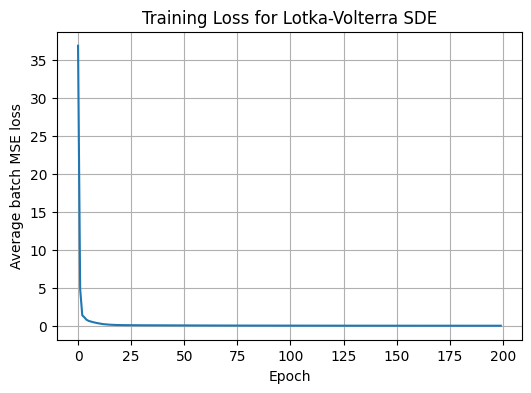

In [ ]:
import matplotlib.pyplot as plt

# ---------------------------------
# Training loop for the Lotka-Volterra SDE
# ---------------------------------
n_batches_lv = n_traj // batch_size
loss_history_lv = []

print("Starting training for the Lotka-Volterra SDE...")
for epoch in range(1, epochs + 1):
    perm_lv = torch.randperm(n_traj, device=device)
    epoch_loss_lv = 0.0
    for b in range(n_batches_lv):
        idx_lv = perm_lv[b * batch_size:(b + 1) * batch_size]
        X_batch_lv = X_data_t_lv[idx_lv]  # (B, N+1)
        Y_batch_lv = Y_data_t_lv[idx_lv]  # (B, N+1)
        dW1_batch_lv = dW1_data_t_lv[idx_lv] # (B, N)
        dW2_batch_lv = dW2_data_t_lv[idx_lv] # (B, N)

        # Forward: build prediction and loss using same dW increments
        x_pred_lv = X_batch_lv[:, 0]  # (B,)
        y_pred_lv = Y_batch_lv[:, 0]  # (B,)
        total_loss_lv = 0.0
        for i in range(N):
            t_now_lv = float(t_grid[i])
            drift_x_pred, drift_y_pred, diff_x_pred, diff_y_pred = network_step_lv(x_pred_lv, y_pred_lv, t_now_lv)

            # Euler-Maruyama scheme for prediction
            x_next_pred_lv = x_pred_lv + drift_x_pred * dt + diff_x_pred * dW1_batch_lv[:, i]
            y_next_pred_lv = y_pred_lv + drift_y_pred * dt + diff_y_pred * dW2_batch_lv[:, i]

            # True next states from data
            x_next_true_lv = X_batch_lv[:, i+1]
            y_next_true_lv = Y_batch_lv[:, i+1]

            # Calculate MSE loss for both X and Y components
            total_loss_lv += mse_loss_lv(x_next_pred_lv, x_next_true_lv)
            total_loss_lv += mse_loss_lv(y_next_pred_lv, y_next_true_lv)

            # Update current predictions for next step
            x_pred_lv = x_next_pred_lv
            y_pred_lv = y_next_pred_lv

        optimizer_lv.zero_grad()
        total_loss_lv.backward()
        optimizer_lv.step()
        epoch_loss_lv += total_loss_lv.item()
    epoch_loss_lv = epoch_loss_lv / n_batches_lv
    loss_history_lv.append(epoch_loss_lv)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, loss = {epoch_loss_lv:.6f}")

print("Training finished for the Lotka-Volterra SDE.")

# ---------------------------------
# Plot loss for the new SDE
# ---------------------------------
plt.figure(figsize=(6,4))
plt.plot(loss_history_lv)
plt.xlabel("Epoch")
plt.ylabel("Average batch MSE loss")
plt.title("Training Loss for Lotka-Volterra SDE")
plt.grid(True)
plt.show()

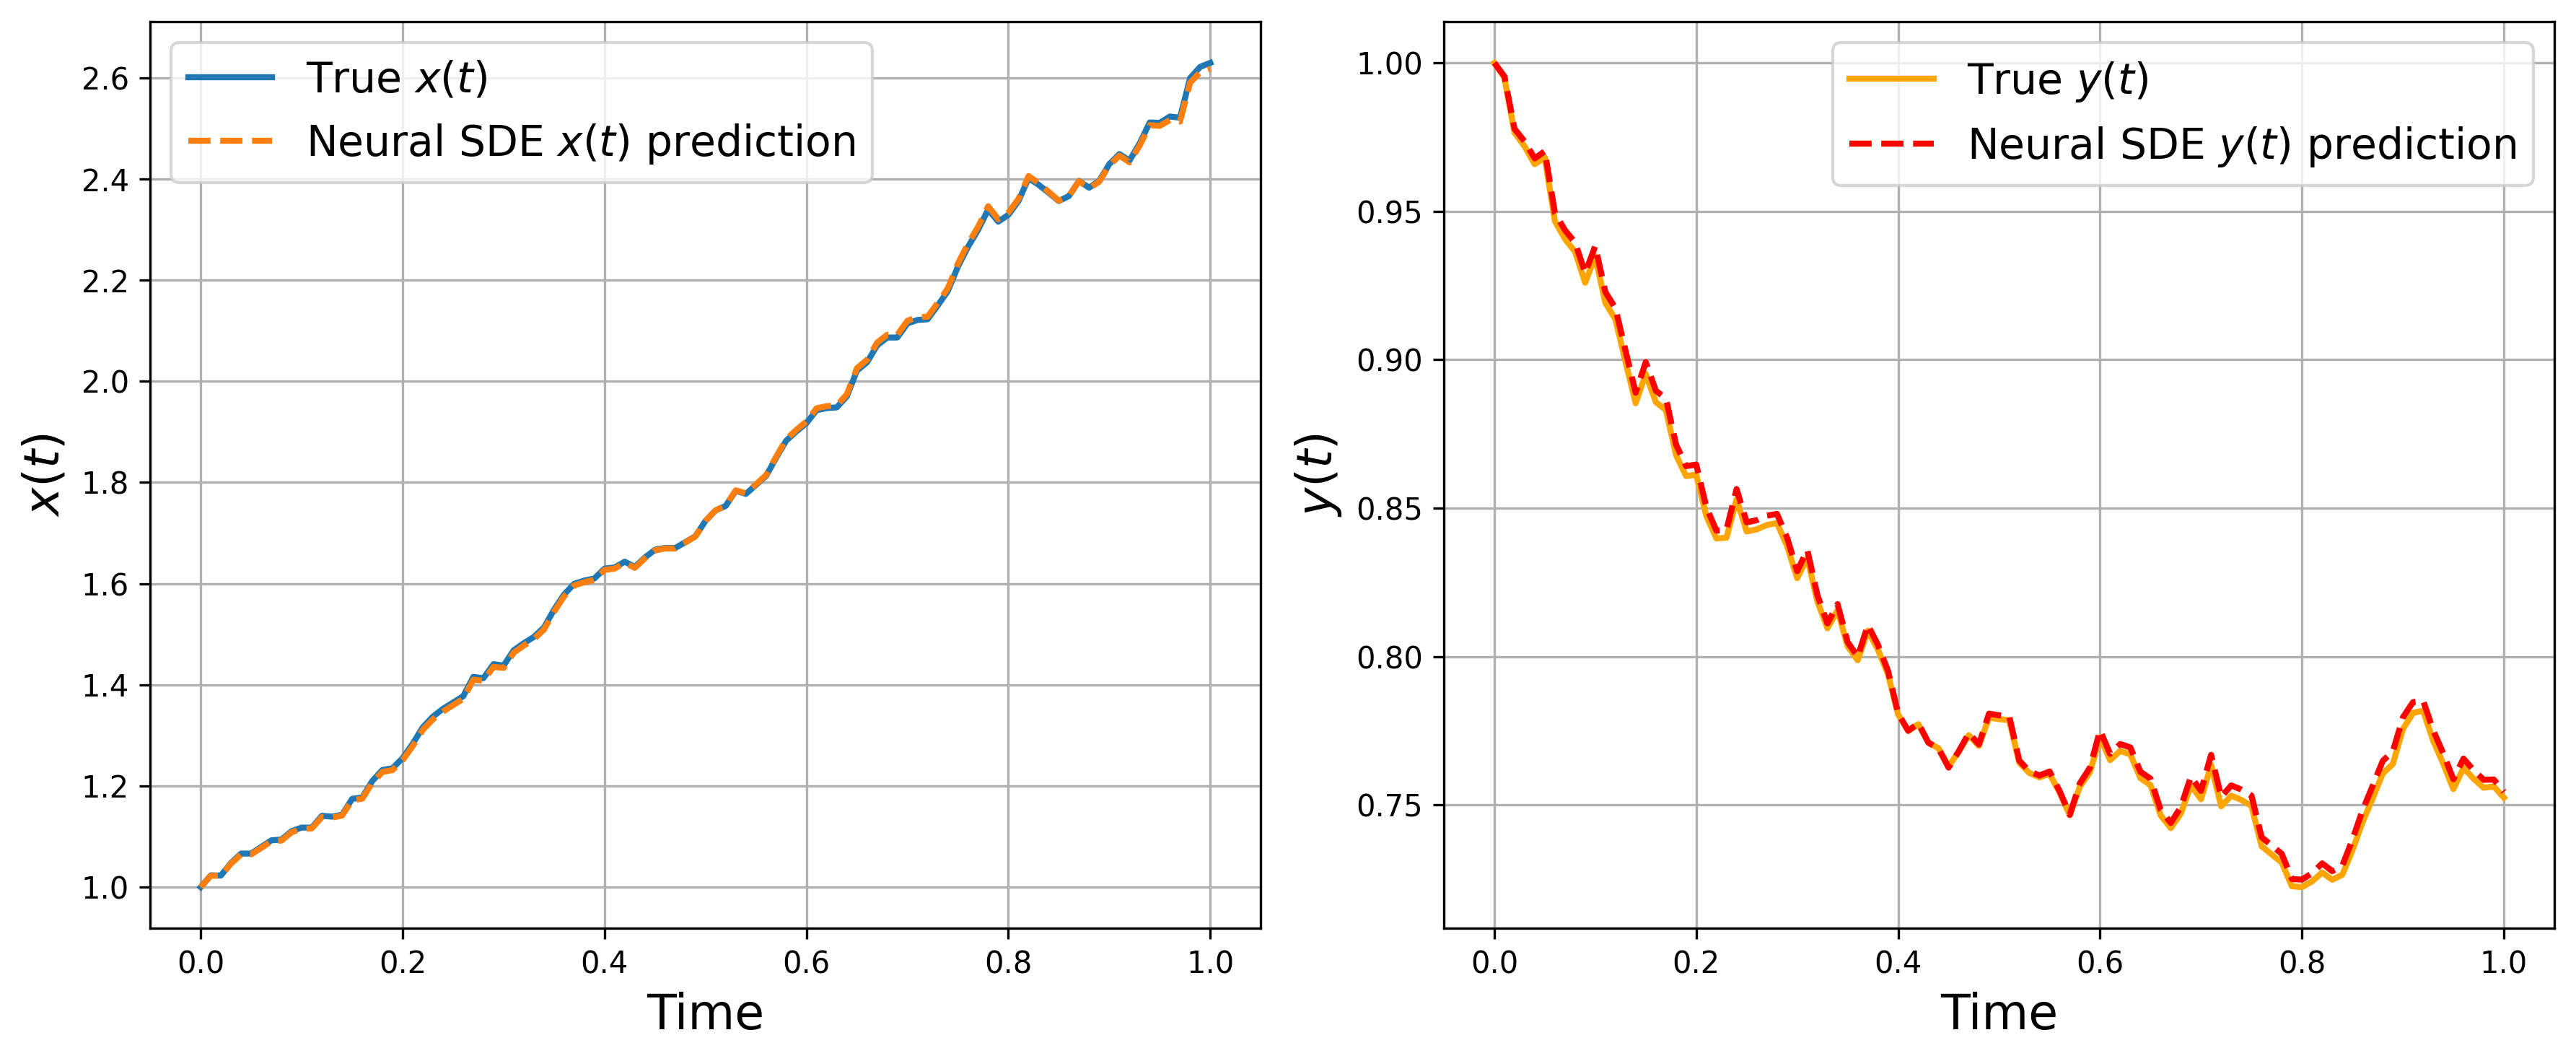


Learned drift/diffusion at t=0 for sample x, y pairs (Lotka-Volterra SDE):
x=0.10, y=0.10 -> 
  Learned dX drift=-0.1516 (True=0.0990), Learned dY drift=-0.8535 (True=-0.1425)
  Learned dX diff=0.0853 (True=0.0100), Learned dY diff=0.1776 (True=0.0100)
x=0.10, y=0.70 -> 
  Learned dX drift=-0.0848 (True=0.0930), Learned dY drift=-1.0813 (True=-0.9975)
  Learned dX diff=0.0667 (True=0.0100), Learned dY diff=0.1403 (True=0.0700)
x=0.10, y=1.30 -> 
  Learned dX drift=-0.0124 (True=0.0870), Learned dY drift=-1.2254 (True=-1.8525)
  Learned dX diff=0.0612 (True=0.0100), Learned dY diff=0.1265 (True=0.1300)
x=0.10, y=1.90 -> 
  Learned dX drift=0.0553 (True=0.0810), Learned dY drift=-1.3033 (True=-2.7075)
  Learned dX diff=0.0634 (True=0.0100), Learned dY diff=0.1249 (True=0.1900)
x=0.10, y=2.50 -> 
  Learned dX drift=0.1114 (True=0.0750), Learned dY drift=-1.3408 (True=-3.5625)
  Learned dX diff=0.0702 (True=0.0100), Learned dY diff=0.1297 (True=0.2500)
x=0.70, y=0.10 -> 
  Learned dX drif

In [ ]:
import matplotlib.pyplot as plt

# -----------------------------------------------------
# Evaluate on one new sample path for the Lotka-Volterra SDE
# -----------------------------------------------------
with torch.no_grad():
    # Simulate a true Lotka-Volterra trajectory
    x_true_lv = np.zeros(N+1, dtype=np.float32)
    y_true_lv = np.zeros(N+1, dtype=np.float32)
    x_true_lv[0] = X0_lv
    y_true_lv[0] = Y0_lv
    dW1_sample_lv = np.random.normal(scale=sqrt_dt, size=N).astype(np.float32)
    dW2_sample_lv = np.random.normal(scale=sqrt_dt, size=N).astype(np.float32)

    for i in range(N):
        # True SDE step for Lotka-Volterra
        drift_x_true = alpha_lv * x_true_lv[i] - beta_lv * x_true_lv[i] * y_true_lv[i]
        drift_y_true = -gamma_lv * y_true_lv[i] + delta_lv * x_true_lv[i] * y_true_lv[i]
        diff_x_true = 0.1 * x_true_lv[i]
        diff_y_true = 0.1 * y_true_lv[i]

        x_true_lv[i+1] = x_true_lv[i] + drift_x_true * dt + diff_x_true * dW1_sample_lv[i]
        y_true_lv[i+1] = y_true_lv[i] + drift_y_true * dt + diff_y_true * dW2_sample_lv[i]

    # Simulate a neural SDE trajectory
    x_model_lv = np.zeros(N+1, dtype=np.float32)
    y_model_lv = np.zeros(N+1, dtype=np.float32)
    x_model_lv[0] = X0_lv
    y_model_lv[0] = Y0_lv

    x_torch_lv = torch.tensor(X0_lv, dtype=torch.get_default_dtype(), device=device).unsqueeze(0)
    y_torch_lv = torch.tensor(Y0_lv, dtype=torch.get_default_dtype(), device=device).unsqueeze(0)

    for i in range(N):
        t_now_lv = float(t_grid[i])
        drift_x_pred, drift_y_pred, diff_x_pred, diff_y_pred = network_step_lv(x_torch_lv, y_torch_lv, t_now_lv)

        dW1_i = torch.tensor(dW1_sample_lv[i], dtype=torch.get_default_dtype(), device=device).unsqueeze(0)
        dW2_i = torch.tensor(dW2_sample_lv[i], dtype=torch.get_default_dtype(), device=device).unsqueeze(0)

        x_next_lv = x_torch_lv + drift_x_pred * dt + diff_x_pred * dW1_i
        y_next_lv = y_torch_lv + drift_y_pred * dt + diff_y_pred * dW2_i

        x_model_lv[i+1] = x_next_lv.item()
        y_model_lv[i+1] = y_next_lv.item()

        x_torch_lv = x_next_lv
        y_torch_lv = y_next_lv

# Plotting trajectories
plt.figure(figsize=(12, 5), dpi =300)

plt.subplot(1, 2, 1)
plt.plot(t_grid, x_true_lv, label="True $x(t)$", linewidth=2)
plt.plot(t_grid, x_model_lv, label="Neural SDE $x(t)$ prediction", linewidth=2, linestyle="--")
plt.xlabel("Time", fontsize = 16)
plt.ylabel("$x(t)$", fontsize = 16)
plt.legend(fontsize = 14)
#plt.title("True vs Neural SDE X-component (Lotka-Volterra)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_grid, y_true_lv, label="True $y(t)$", linewidth=2, color='orange')
plt.plot(t_grid, y_model_lv, label="Neural SDE $y(t)$ prediction", linewidth=2, linestyle="--", color='red')
plt.xlabel("Time", fontsize = 16)
plt.ylabel("$y(t)$", fontsize = 16)
plt.legend(fontsize = 14)
#plt.title("True vs Neural SDE Y-component (Lotka-Volterra)")
plt.grid(True)

plt.tight_layout()
plt.show()

# -----------------------------------------------------
# Print sample learned drift/diffusion for the Lotka-Volterra SDE
# -----------------------------------------------------
# Adjust range based on expected X_t and Y_t values for Lotka-Volterra SDE
xs_lv = torch.linspace(0.1, 2.5, 5, device=device)
ys_lv = torch.linspace(0.1, 2.5, 5, device=device)

print("\nLearned drift/diffusion at t=0 for sample x, y pairs (Lotka-Volterra SDE):")
with torch.no_grad():
    for xi in xs_lv:
        for yi in ys_lv:
            drift_x_pred, drift_y_pred, diff_x_pred, diff_y_pred = network_step_lv(xi.unsqueeze(0), yi.unsqueeze(0), 0.0)

            # Compare with true values
            true_drift_x = alpha_lv * xi - beta_lv * xi * yi
            true_drift_y = -gamma_lv * yi + delta_lv * xi * yi
            true_diff_x = 0.1 * xi
            true_diff_y = 0.1 * yi

            print(f"x={xi.item():.2f}, y={yi.item():.2f} -> ")
            print(f"  Learned dX drift={drift_x_pred.item():.4f} (True={true_drift_x.item():.4f}), Learned dY drift={drift_y_pred.item():.4f} (True={true_drift_y.item():.4f})")
            print(f"  Learned dX diff={diff_x_pred.item():.4f} (True={true_diff_x.item():.4f}), Learned dY diff={diff_y_pred.item():.4f} (True={true_diff_y.item():.4f})")

# Save weights for the Lotka-Volterra SDE model
torch.save(drift_net_lv.state_dict(), "drift_net_lv_sde.pth")
torch.save(diffusion_net_lv.state_dict(), "diffusion_net_lv_sde.pth")
print("\nSaved Lotka-Volterra model weights to current directory (drift_net_lv_sde.pth, diffusion_net_lv_sde.pth)")